In [1]:
import poliastro as PA
import numpy as np
import matplotlib.pyplot as plt
import time as time_pkg

from astropy import units as u

from poliastro.bodies import Earth, Body
from poliastro.twobody import Orbit
from poliastro.examples import iss

from scipy.stats import expon, uniform, norm, triang
from scipy.special import comb

from lib.GPUKeplerSimulation import propagate, average_scaler, average_3vector
from lib.DisplaySimulation import displaySimulation

In [2]:
# Exponential Distribution
size = 100

J_1 = expon.rvs(scale=1, loc=0.0, size=size)

exponential_var2 = expon.rvs(scale=0.01, loc=0, size=size)
J_2 = J_1 - exponential_var2

for i in range(0,size):
    if J_2[i] < 0.0:
        J_2[i] = 0.0001

exponential_var3 = expon.rvs(scale=0.1, loc=0, size=size)
J_3 = J_2 - exponential_var3

for i in range(0,size):
    if J_3[i] < -J_2[i]:
        J_3[i] = -J_2[i]

M = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
w = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
Omega = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad

In [ ]:
# Near Circular Distribution
size = 500
r_0 = 1*u.km
sigma_e = 0.01*np.sqrt(1*u.km)
sigma_a = 0.000*np.sqrt(1*u.km)
alpha_over_m = 1*u.km**3/u.s**2 


expvar1 = expon.rvs(scale=sigma_e, loc=0, size=size)*np.sqrt(1*u.km)

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = expvar1 + J_2
J_3 = J_2

M = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [ ]:
# Near Gausian in R Distribution
size = 500
r_0 = 1*u.km
sigma_r = 0.5*u.kg*u.km**2
alpha_over_m = 1*u.km**3/u.s**2 


expvar1 = expon.rvs(scale=1, loc=0, size=size)

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = np.sqrt((np.power(J_2, 2) + np.sqrt(np.power(J_2, 4) + sigma_r*expvar1))/2.0)
J_3 = J_2

M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [2]:
# Near SHO Distribution
# Here I'm setting J_SHO = sqrt(ma^3/2k) * (p^2/2m + k/a^3*x^2)
# This leads to J_SHO = sqrt(ka/2)e^2 = sqrt(k/2)(J_1 - J_2^2/J_1)
# Then im distributing particles according to exp{- J_SHO/epsilon}

size = 20000
r_0 = 0.05*u.km
epsilon = 0.0000001*u.kg*u.km**2/u.s
k = 0.00112*u.kg*u.km**3/u.s**2 
m = 0.1*u.kg

J_SHO = expon.rvs(scale=epsilon, loc=0, size=size)*1*u.kg*u.km**2/u.s

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = (J_SHO + np.sqrt(np.power(J_SHO, 2) + 4*k*m*np.power(J_2, 2)))/(2.0*np.sqrt(k*m))
J_3 = J_2

M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [3]:
omega = np.sqrt(k/m)/np.power(r_0, 3.0/2.0)
omega_prime = -3/(2*m*np.power(r_0, 2.0))
print("Omega_0: ", omega)
print("Omega_prime: ", omega_prime)
print("Decoherance Time: ", 2*np.pi/(omega_prime*epsilon))

# average_radius = 3*sigma_e**2 + 3*sigma_e*sigma_a + 3*sigma_e*np.sqrt(r_0) + 2*sigma_a**2 + 2*sigma_a*np.sqrt(r_0) + r_0
# print("Inital average radius: ", average_radius)

Omega_0:  9.465727652959384 1 / s
Omega_prime:  -5999.999999999998 1 / (kg km2)
Decoherance Time:  -10471.97551196598 s


In [4]:
a = np.square(J_1)
ecc = np.sqrt(1 - np.square(J_2/J_1)) * u.one
inc = np.arccos(J_3/J_2)

GM = Body(None, k/m, "Central Body")

In [5]:
class AsteriodBelt:
    size = 0
    micro = 1*u.km**3/u.s**2
    a = np.array([])*u.km
    ecc = np.array([])*u.one
    inc = np.array([])*u.rad
    Omega = np.array([])*u.rad
    w = np.array([])*u.rad
    M = np.array([])*u.rad
    def __init__(self, _size, _micro, _a, _ecc, _inc, _Omega, _w, _M):
        self.size = _size
        self.micro = _micro
        self.a = _a
        self.ecc = _ecc
        self.inc = _inc
        self.Omega = _Omega
        self.w = _w
        self.M = _M
        
    def setMeanAnamoly(self, _M):
        self.M = _M

In [6]:
belt = AsteriodBelt(size, k/m, a, ecc, inc, Omega, w, M)

In [27]:
timestep = 0.1*u.second

time_before_kick = 300*u.second
time_after_kick = 1000*u.second
time_after_quad_kick = 1300*u.second

dipole_time = time_before_kick
quad_time = time_before_kick + time_after_kick
end_time = time_before_kick + time_after_kick + time_after_quad_kick

dipole_step = int(dipole_time/timestep)
quad_step = int(quad_time/timestep)
end_step = int(end_time/timestep)


time = np.linspace(0.0*u.second, end_time, end_step)

avr_radius = np.zeros(end_step) * u.km

radiuses = np.zeros((size, end_step)) * u.km
velocities = np.zeros((size, end_step)) * u.km/u.s

In [28]:
gpuStart = time_pkg.time()
radiuses[:,0:dipole_step], velocities[:,0:dipole_step], final_mean_anamoly = propagate(belt, dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU memory size:  6871580672
Running  6  memory frames
[[ 1.09650496  2.04334343  2.9901819  ...  3.10658394  4.05342241
   5.00026088]
 [ 1.75868198  2.70554607  3.65241015 ...  3.78241583  4.72927991
   5.676144  ]
 [ 3.66275609  4.60863704  5.55451798 ...  5.16247452  6.10835547
   7.05423641]
 ...
 [-1.43643747 -0.48965454  0.4571284  ...  0.54404245  1.49082539
   2.43760832]
 [ 0.32046977  1.26619073  2.2119117  ...  1.73492024  2.68064121
   3.62636217]
 [ 6.220163    7.16580814  8.11145328 ...  7.59419759  8.53984273
   9.48548787]]
 Obj Extract:  0.005499362945556641  E Calc:  0.3449997901916504
[[ 5.94709934  6.89393781  1.55759097 ...  1.67399301  2.62083148
   3.56766995]
 [ 6.62300809  7.56987217  2.23355095 ...  2.36355663  3.31042071
   4.2572848 ]
 [ 8.00011735  8.9459983   9.89187924 ...  9.49983578  4.16253142
   5.10841236]
 ...
 [ 3.38439126  4.33117419 -1.00522818 ... -0.91831413  0.02846881
   0.97525174]
 [ 4.57208314  5.51780411  6.46352507 ...  5.98653361  0.64

In [29]:
avr_radius[0:dipole_step] = average_scaler(radiuses, end=dipole_step)

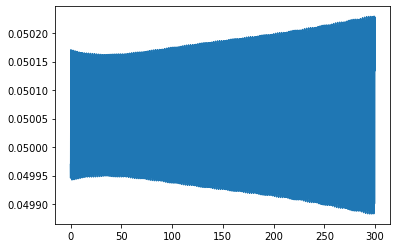

In [30]:
plt.plot(time[0:dipole_step], avr_radius[0:dipole_step])

In [31]:
unit_r = np.empty(3) 
newR = np.empty(3)

orb = [None]*belt.size

for i in range(0, belt.size):
    orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

kickStrength = 0.001*u.km

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        old_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        newPosition = orb[i].r + kickStrength*unit_r
        oldThetaVelocity = orb[i].v - np.dot(orb[i].v, unit_r)*unit_r
        newThetaVelocity = old_radius/(old_radius + kickStrength)*oldThetaVelocity
        newVelocity = np.dot(orb[i].v, unit_r)*unit_r + newThetaVelocity
        orb[i] = Orbit.from_vectors(GM, newPosition, newVelocity)
        belt.a[i] = orb[i].a
        belt.ecc[i] = orb[i].ecc
        belt.inc[i] = orb[i].inc
        belt.Omega[i] = orb[i].raan
        belt.w[i] = orb[i].argp
        belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
        new_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        if old_r_0 - new_r_0 > 10**-12*u.km:
            print("L_2 before and after do not match: ", old_r_0, "\t", new_r_0)
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
        if (orb[i].r != newPosition).any():
            print("r got missassigned.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [32]:
gpuStart = time_pkg.time()
radiuses[:,dipole_step:quad_step], velocities[:,dipole_step:quad_step], final_mean_anamoly = propagate(belt, quad_time-dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU memory size:  6871580672
Running  19  memory frames
[[ 2.89677581  3.8430994   4.78942298 ...  4.63242299  5.57874658
   6.52507017]
 [ 2.92125178  3.86738576  4.81351974 ...  4.5558376   5.50197158
   6.44810556]
 [ 1.11853638  2.06505215  3.01156792 ...  2.95661474  3.90313051
   4.84964627]
 ...
 [-2.80654298 -1.86073137 -0.91491975 ... -1.34377885 -0.39796724
   0.54784437]
 [ 2.9281353   3.87171277  4.81529025 ...  3.20010713  4.14368461
   5.08726208]
 [ 2.51721535  3.46118273  4.4051501  ...  2.99700218  3.94096956
   4.88493694]]
 Obj Extract:  0.0005002021789550781  E Calc:  0.27450037002563477
[[ 7.47139375  8.41771734  3.08085562 ...  2.92385563  3.87017922
   4.81650281]
 [ 7.39423954  8.34037351  3.00332219 ...  9.02882536  3.69177403
   4.63790801]
 [ 5.79616204  6.7426778   1.40600826 ...  1.35105509  2.29757085
   3.24408662]
 ...
 [ 1.49365598  2.43946759  3.3852792  ...  2.95642011 -2.38095359
  -1.43514198]
 [ 6.03083956  6.97441704  7.91799452 ...  6.3028114   7

In [33]:
avr_radius[dipole_step:quad_step] = average_scaler(radiuses, start=dipole_step, end=quad_step)

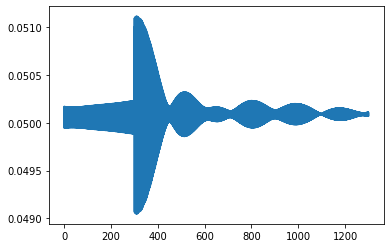

In [34]:
plt.plot(time[0:quad_step], avr_radius[0:quad_step])

In [35]:
unit_r = np.empty(3) 
newR = np.empty(3)

for i in range(0, belt.size):
    orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

quad_strength = 0.35 * u.second**-1
radius_offset = r_0

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        newVelocity = orb[i].v + quad_strength*(old_radius - radius_offset)*unit_r
        orb[i] = Orbit.from_vectors(GM, orb[i].r, newVelocity)
        belt.a[i] = orb[i].a
        belt.ecc[i] = orb[i].ecc
        belt.inc[i] = orb[i].inc
        belt.Omega[i] = orb[i].raan
        belt.w[i] = orb[i].argp
        belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [36]:
gpuStart = time_pkg.time()
radiuses[:,quad_step:end_step], velocities[:,quad_step:end_step], final_mean_anamoly = propagate(belt, end_time - quad_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

GPU memory size:  6871580672
Running  25  memory frames
[[ 2.66456596  3.6108575   4.55714903 ...  4.38313071  5.32942225
   6.27571378]
 [ 0.79349791  1.7396291   2.68576029 ...  2.42659647  3.37272765
   4.31885884]
 [ 2.81198316  3.75847379  4.70496442 ...  4.63666569  5.58315632
   6.52964696]
 ...
 [-1.78546918 -0.83966368  0.10614181 ... -0.32596602  0.61983947
   1.56564496]
 [ 0.35104036  1.29467357  2.23830677 ...  0.65271426  1.59634747
   2.53998067]
 [-2.34230203 -1.39825559 -0.45420915 ... -1.82037263 -0.87632619
   0.06772026]]
 Obj Extract:  0.000997781753540039  E Calc:  0.33416032791137695
[[ 7.22200532  8.16829686  2.83140309 ...  8.94057007  3.6036763
   4.54996784]
 [ 5.26499003  6.21112122  0.8740671  ...  6.89808858  1.56103446
   2.50716565]
 [ 7.47613759  8.42262822  3.08593355 ...  3.01763482  3.96412545
   4.91061608]
 ...
 [ 2.51145046  3.45725595  4.40306144 ...  3.97095361 -1.36642621
  -0.42062071]
 [ 3.48361388  4.42724708  5.37088029 ...  3.78528778  4.7

In [39]:
avr_radius[quad_step:end_step] = average_scaler(radiuses[quad_step:end_step], start=quad_step, end=end_step)

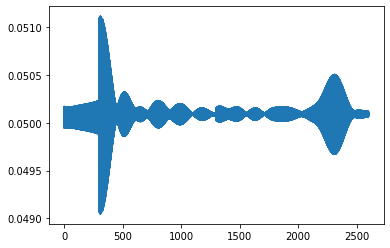

In [40]:
plt.plot(time[0:end_step], avr_radius[0:end_step])